In [2]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
!pip install -q transformers

ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'd:\\conda\\envs\\tesi2\\lib\\site-packages\\~ensorflow\\python\\_pywrap_tensorflow_internal.pyd'
Consider using the `--user` option or check the permissions.

  ERROR: Command errored out with exit status 1:
   command: 'D:\conda\envs\tesi2\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\orazi\\AppData\\Local\\Temp\\pip-install-2k89dokz\\pycocotools_b76995d37ae34f899b6cad8257ebe984\\setup.py'"'"'; __file__='"'"'C:\\Users\\orazi\\AppData\\Local\\Temp\\pip-install-2k89dokz\\pycocotools_b76995d37ae34f899b6cad8257ebe984\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\orazi\AppData\Local\Temp\pip-wheel-m_lvyo_t'
       c

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import pandas as pd
from modules.dataframe_tools import *
from modules.utils import *
from modules.metrics import *
from modules.BERTmodels import *
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoTokenizer, TFAutoModel, logging
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import load_model


logging.set_verbosity_warning(40)


ModuleNotFoundError: No module named 'transformers'

In [ ]:
saved_models_folder = "/content/drive/MyDrive/NLP/proj finale/saved_models/"

## Create Models

In [105]:
max_len = 512
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

inputs = [input_ids, token_type_ids, attention_mask]

In [106]:
bert_cnn = create_bert_CNN()
bert_van = create_bert_vanilla()
bert_add = create_bert_custom(custom_layer="add", inputs = inputs)
bert_avg = create_bert_custom(custom_layer="average", inputs = inputs)
bert_max = create_bert_custom(custom_layer="maximum", inputs = inputs)
bert_min = create_bert_custom(custom_layer="minimum", inputs = inputs)
bert_mul = create_bert_custom(custom_layer="multiply", inputs = inputs)
bert_sub = create_bert_custom(custom_layer="subtract", inputs = inputs)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

## Load Weights

In [ ]:
for file_name in os.listdir(saved_models_folder):
  if file_name.endswith(".hdf5"):
    saved_model = saved_models_folder + "/" + file_name
    print(file_name)


BERT_1DConv.hdf5
BERT_Vanilla.hdf5
bert-base-uncased.hdf5
bert-base-uncased_average.hdf5
bert-base-uncased_maximum.hdf5
bert-base-uncased_add.hdf5
bert-base-uncased_minimum.hdf5
bert-base-uncased_subtract.hdf5
bert-base-uncased_multiply.hdf5


In [ ]:
bert_cnn.load_weights(saved_models_folder + "BERT_1DConv.hdf5")
bert_van.load_weights(saved_models_folder + "BERT_Vanilla.hdf5")
bert_add.load_weights(saved_models_folder + "bert-base-uncased_add.hdf5")
bert_avg.load_weights(saved_models_folder + "bert-base-uncased_average.hdf5")
bert_max.load_weights(saved_models_folder + "bert-base-uncased_maximum.hdf5")
bert_min.load_weights(saved_models_folder + "bert-base-uncased_minimum.hdf5")
bert_mul.load_weights(saved_models_folder + "bert-base-uncased_multiply.hdf5")
bert_sub.load_weights(saved_models_folder + "bert-base-uncased_subtract.hdf5")

In [109]:
models = [
          bert_cnn,
          bert_van,
          bert_add,
          bert_avg,
          bert_max,
          bert_min,
          bert_mul,
          bert_sub
]

In [ ]:
max_len = 512

# Save the slow pretrained tokenizer
model_name = 'bert-base-uncased'

path = '/content/drive/MyDrive/NLP/proj finale/dataset'
tokenizer = AutoTokenizer.from_pretrained(model_name)


with open(path+'/training_set.json') as f:
    raw_train_data = json.load(f)

df_orig = create_df(raw_train_data, [])

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

## Ensemble

In [110]:
ens_model = EnsembleModel(models, inputs)

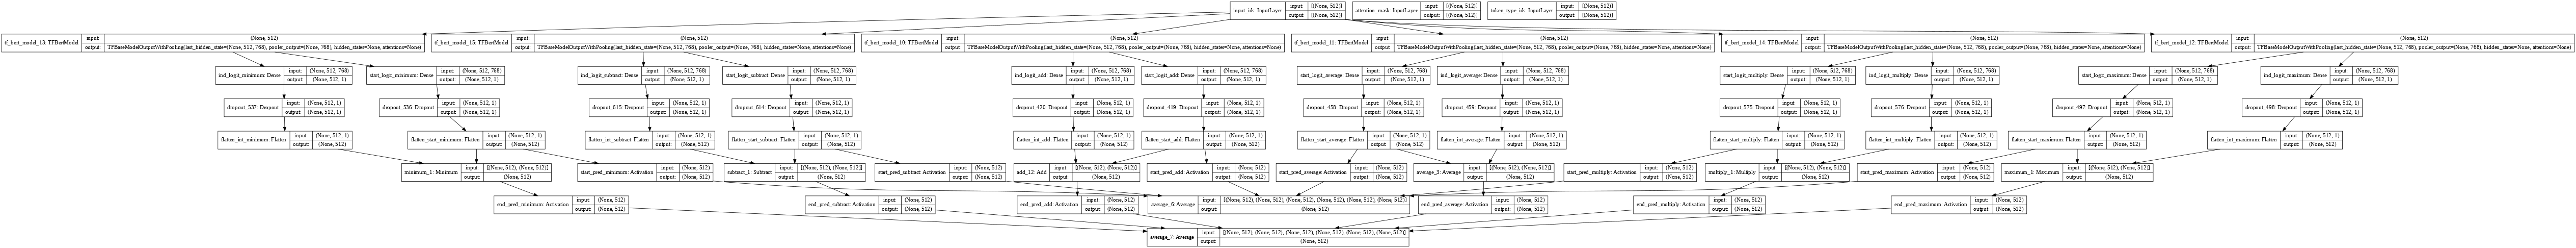

In [111]:
ens_model.plot_model()

In [ ]:
df = process_dataset(df_orig, tokenizer, answer_available=True, max_len=max_len)
# x_train,y_train, x_val, y_val = train_test_split_on_title(df)
x, y = dataframe_to_array(df)
p = ens_model.predict(x)

data = {"pred_start":df["start_token_idx"],
        "pred_end": df["end_token_idx"], 
        "true_start": p[0], 
         "true_end":p[1]}
df_ev = pd.DataFrame.from_dict(data)

print_prediction(p, df_orig)
print(f1_score(df_ev))
print(exact_match(df_ev))

